In [1]:
#!pip install tensorflow

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
imageSize = 256   # Setting the image size as that of properties
batchSize = 32    # Making a group of 32 images
channels = 3      # RGB values
epochs = 10       # 
df = pd.DataFrame(columns=['Plant','Accuracy','Loss'])

In [3]:
#Potato plant
potato_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PotatoPlant",
    shuffle=True,
    image_size = (imageSize,imageSize),
    batch_size = batchSize
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = potato_dataset.class_names
class_names   #Names of folder present in PotatoPlant

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(potato_dataset)

68

In [6]:
68*32    #length of dataset and batch size

2176

In [7]:
for image_batch, label_batch in potato_dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
#Basically it provides a batch size, image size and RGB channels
#label batch signifies the class number

(32, 256, 256, 3)
[0 0 0 1 2 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 0 0 0]


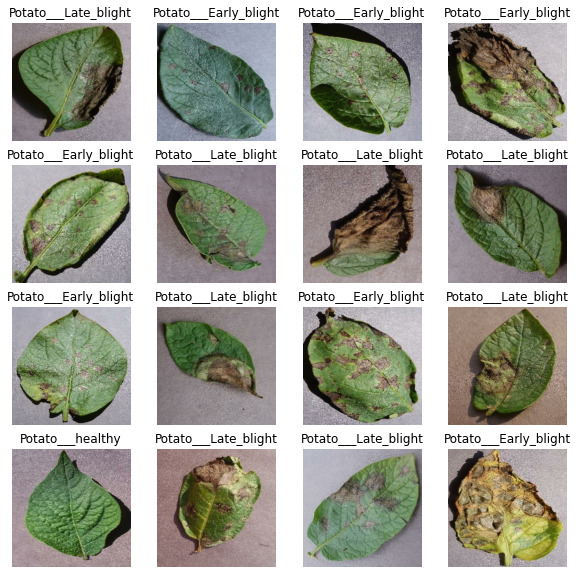

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in potato_dataset.take(1):
    for i in range(16):    #here in range max value we can give is 32 bcoz batch size is 32
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
len(potato_dataset)

68

In [10]:
# 70% -> Training dataset
# 15% -> Validation dataset
# 15% -> Testing dataset
train_size = 0.7
len(potato_dataset)*train_size

47.599999999999994

In [11]:
train_potatodataset = potato_dataset.take(47)   # Considering first 47 values
len(train_potatodataset)

47

In [12]:
test_potatodataset = potato_dataset.skip(47)    # Considering values after 47
len(test_potatodataset)

21

In [13]:
validation_size = 0.15
len(potato_dataset)*validation_size

10.2

In [14]:
validation_potatodataset = test_potatodataset.take(10)
len(validation_potatodataset)

10

In [15]:
test_potatodataset = test_potatodataset.skip(10)
len(test_potatodataset)

11

In [16]:
def get_dataset_partitions_tf(ds, train_split = 0.7, val_split = 0.15, test_split = 0.15, shuffle=True, shuffle_size=10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 15)
        
    ds_size = len(ds)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    test_size = int(test_split*ds_size)
    
    train_ds = ds.take(train_size)
    validation_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, validation_ds, test_ds

In [17]:
train_ds, validation_ds, test_ds = get_dataset_partitions_tf(potato_dataset)

In [18]:
print(len(train_ds))
print(len(validation_ds))
print(len(test_ds))

47
10
11


In [19]:
# Here cache is used to store the image so that we can read the image from the disk which improves the performance.
# Prefetch is used because if GPU is busy with training purpose meanwhile CPU will read the next batch so that the performance is optimized.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
#Thus we get the optimized Training, Validation and Testing dataset.

In [20]:
#Data preprocessing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(imageSize, imageSize),   #Suppose if the size of image is not 256 then this will take care of that.
    layers.experimental.preprocessing.Rescaling(1.0/255)   #Rescaling the image to 255 and supply the layer when we actually build our model.
])

In [21]:
#Data augmentation :- Techniques used to increase the amount of data by adding slightly modified copies of already existing data
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])
#We just created layers for preprocessing and we will this layer in our actual model.

In [22]:
input_shape = (batchSize, imageSize, imageSize, channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'), #softmax function -> normalize the probability of your classes.
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [24]:
model.compile(
        optimizer = 'adam',
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
        metrics = ['accuracy']   #to track the gradient descent/ training process.
)

In [25]:
epochs = 10
results = model.fit(
    train_ds,
    batch_size=batchSize,
    validation_data=validation_ds,
    verbose=1,
    epochs=epochs,
)

Epoch 1/10
47/47 [==============================] - 57s 1s/step - loss: 0.9142 - accuracy: 0.4851 - val_loss: 0.9461 - val_accuracy: 0.4062
Epoch 2/10
47/47 [==============================] - 54s 1s/step - loss: 0.8472 - accuracy: 0.5750 - val_loss: 0.6301 - val_accuracy: 0.7625
Epoch 3/10
47/47 [==============================] - 53s 1s/step - loss: 0.6181 - accuracy: 0.7514 - val_loss: 0.5407 - val_accuracy: 0.7781
Epoch 4/10
47/47 [==============================] - 55s 1s/step - loss: 0.4703 - accuracy: 0.8088 - val_loss: 0.3975 - val_accuracy: 0.8531
Epoch 5/10
47/47 [==============================] - 53s 1s/step - loss: 0.3794 - accuracy: 0.8581 - val_loss: 0.2806 - val_accuracy: 0.8844
Epoch 6/10
47/47 [==============================] - 53s 1s/step - loss: 0.2604 - accuracy: 0.8926 - val_loss: 0.2314 - val_accuracy: 0.9094
Epoch 7/10
47/47 [==============================] - 53s 1s/step - loss: 0.2346 - accuracy: 0.9068 - val_loss: 0.2991 - val_accuracy: 0.8687
Epoch 8/10
47/47 [==

In [26]:
scores = model.evaluate(test_ds) #Testing accuracy

11/11 [==============================] - 3s 224ms/step - loss: 0.1240 - accuracy: 0.9489


In [27]:
scores      #returns loss and accuracy

[0.12404393404722214, 0.9488636255264282]

In [28]:
results   #history

In [29]:
results.params

{'verbose': 1, 'epochs': 10, 'steps': 47}

In [30]:
results.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
accuracy = results.history['accuracy']
val_accuracy = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']

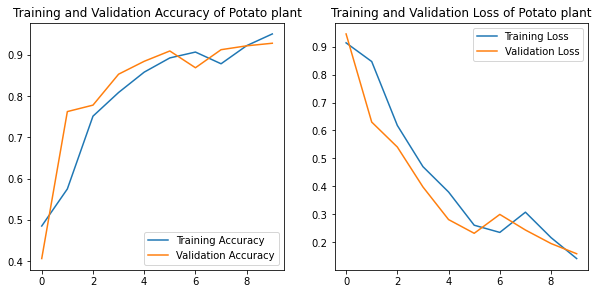

In [40]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(range(epochs), accuracy, label='Training Accuracy')
plt.plot(range(epochs), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy of Potato plant')

plt.subplot(2, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss of Potato plant')
plt.show()

Predicting the first image
Actual class label: Potato___Early_blight
Predicted class label: Potato___Late_blight


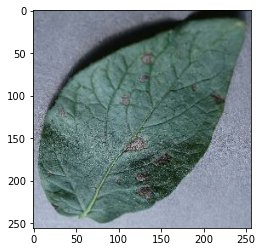

In [41]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):    # where 1 is the number of batches
    #print(images_batch[0])    #Tensor format
    #print(images_batch[0].numpy())     #Numpy format
    #plt.imshow(images_batch[0].numpy().astype('uint8'))    #Displays the actual image
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("Predicting the first image")
    plt.imshow(first_image)
    print("Actual class label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted class label:",class_names[np.argmax(batch_prediction[0])])

In [42]:
#Creating a function for inference
def predict_model(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

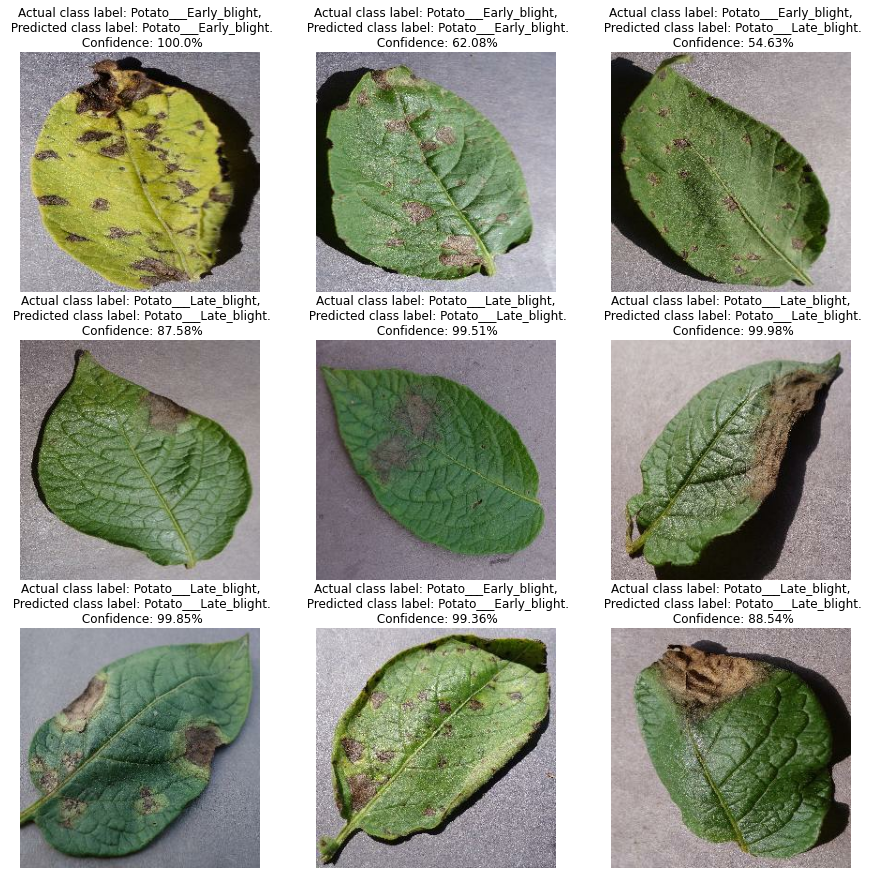

In [43]:
#Running the inference on few sample images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):   #Taking 1 batch
    for i in range(9):    #Considering 9 images at a time
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict_model(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual class label: {actual_class},\n Predicted class label: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")   #Removing the axes

In [44]:
import os
model_version=max([int(i) for i in os.listdir("saved_models/") + [0]])+1
model.save(f"./saved_models/{model_version}")

INFO:tensorflow:Assets written to: ./saved_models/3\assets


In [48]:
df.loc[len(df.index)] = ['Potato', scores[1], scores[0]]

In [49]:
df

Plant  Accuracy      Loss
0  Potato  0.948864  0.124044

In [50]:
#imageSize = 256   
#batchSize = 32    
#channels = 3      
#epochs = 50 

#BellPepper plant
bellpepper_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "BellPepperPlant",
    shuffle=True,
    image_size = (imageSize,imageSize),
    batch_size = batchSize
)

Found 2475 files belonging to 2 classes.


In [51]:
bellpepper_class_names = bellpepper_dataset.class_names
bellpepper_class_names   #Names of folder present in BellPepperPlant

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [52]:
len(bellpepper_dataset)

78

In [53]:
78*32

2496

In [54]:
for image_batch, label_batch in bellpepper_dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
#Basically it provides a batch size, image size and RGB channels
#label batch signifies the class number

(32, 256, 256, 3)
[1 0 0 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0]


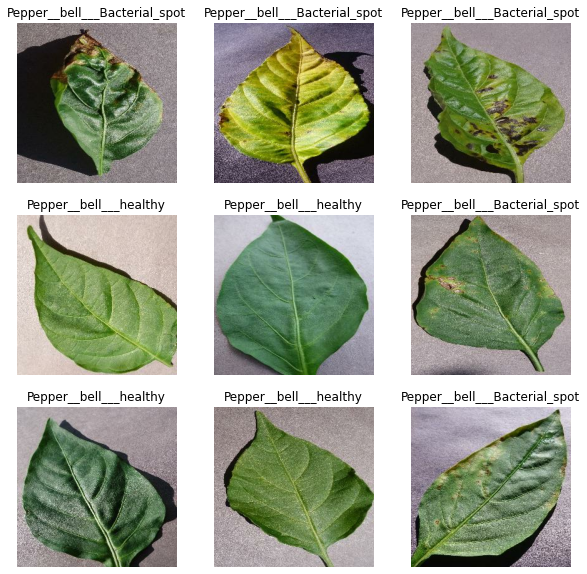

In [55]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in bellpepper_dataset.take(1):
    for i in range(9):    #here in range max value we can give is 32 bcoz batch size is 32
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(bellpepper_class_names[label_batch[i]])
        plt.axis("off")

In [56]:
len(bellpepper_dataset)

78

In [57]:
# 70% -> Training dataset
# 15% -> Validation dataset
# 15% -> Testing dataset
train_size = 0.7
len(bellpepper_dataset)*train_size

54.599999999999994

In [58]:
train_bellpepperdataset = bellpepper_dataset.take(54)   # Considering first 54 values
len(train_bellpepperdataset)

54

In [59]:
test_bellpepperdataset = bellpepper_dataset.skip(54)   # Considering values after 54
len(test_bellpepperdataset)

24

In [60]:
validation_size = 0.15
len(bellpepper_dataset)*validation_size

11.7

In [61]:
validation_bellpepperdataset = test_bellpepperdataset.take(11)
len(validation_bellpepperdataset)

11

In [62]:
test_bellpepperdataset = test_bellpepperdataset.skip(11)
len(test_bellpepperdataset)

13

In [63]:
train_bellpepperds, validation_bellpepperds, test_bellpepperds = get_dataset_partitions_tf(bellpepper_dataset)

In [64]:
print(len(train_bellpepperds))
print(len(validation_bellpepperds))
print(len(test_bellpepperds))

54
11
13


In [65]:
# Here cache is used to store the image so that we can read the image from the disk which improves the performance.
# Prefetch is used because if GPU is busy with training purpose meanwhile CPU will read the next batch so that the performance is optimized.
train_bellpepperds = train_bellpepperds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_bellpepperds = validation_bellpepperds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_bellpepperds = test_bellpepperds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
#Thus we get the optimized Training, Validation and Testing dataset.

In [66]:
#Data preprocessing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(imageSize, imageSize),   #Supose if the size of image is not 256 then this will take care of that.
    layers.experimental.preprocessing.Rescaling(1.0/255)   #Rescaling the image to 255 and supply the layer when we actually build our model.
])

In [67]:
#Data augmentation :- Techniques used to increase the amount of data by adding slightly modified copies of already existing data
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])
#We just created layers for preprocessing and we will this layer in our actual model.

In [68]:
input_shape = (batchSize, imageSize, imageSize, channels)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'), #softmax function -> normalize the probability of your classes.
])

model.build(input_shape=input_shape)

In [69]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [70]:
model.compile(
        optimizer = 'adam',
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
        metrics = ['accuracy']   #to track the gradient descent/ training process.
)

In [71]:
epochs = 10
results = model.fit(
    train_bellpepperds,
    batch_size=batchSize,
    validation_data=validation_bellpepperds,
    verbose=1,
    epochs=epochs,
)

Epoch 1/10
54/54 [==============================] - 65s 1s/step - loss: 0.5455 - accuracy: 0.7165 - val_loss: 0.3494 - val_accuracy: 0.9205
Epoch 2/10
54/54 [==============================] - 61s 1s/step - loss: 0.2897 - accuracy: 0.9168 - val_loss: 0.1635 - val_accuracy: 0.9432
Epoch 3/10
54/54 [==============================] - 61s 1s/step - loss: 0.1530 - accuracy: 0.9502 - val_loss: 0.0796 - val_accuracy: 0.9688
Epoch 4/10
54/54 [==============================] - 61s 1s/step - loss: 0.1167 - accuracy: 0.9660 - val_loss: 0.0526 - val_accuracy: 0.9744
Epoch 5/10
54/54 [==============================] - 61s 1s/step - loss: 0.0868 - accuracy: 0.9777 - val_loss: 0.0451 - val_accuracy: 0.9801
Epoch 6/10
54/54 [==============================] - 61s 1s/step - loss: 0.0551 - accuracy: 0.9836 - val_loss: 0.0382 - val_accuracy: 0.9915
Epoch 7/10
54/54 [==============================] - 61s 1s/step - loss: 0.0281 - accuracy: 0.9924 - val_loss: 0.0166 - val_accuracy: 0.9915
Epoch 8/10
54/54 [==

In [72]:
scores = model.evaluate(test_bellpepperds)

13/13 [==============================] - 4s 219ms/step - loss: 0.0243 - accuracy: 0.9904


In [73]:
scores      #returns loss and accuracy

[0.02432667464017868, 0.9903846383094788]

In [74]:
results     #history

In [75]:
results.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [76]:
results.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [77]:
accuracy = results.history['accuracy']
val_accuracy = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']

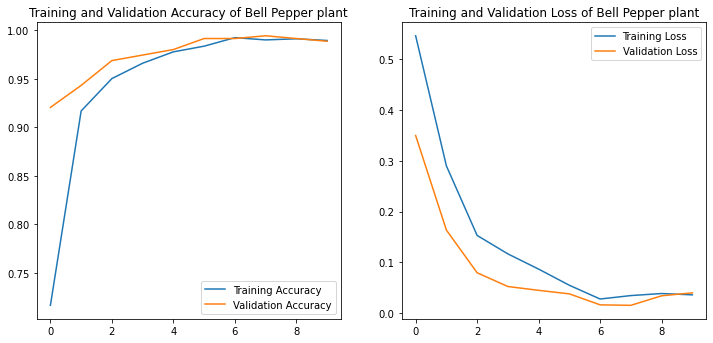

In [80]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(range(epochs), accuracy, label='Training Accuracy')
plt.plot(range(epochs), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy of Bell Pepper plant')

plt.subplot(2, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss of Bell Pepper plant')
plt.show()

Predicting the first image
Actual class label: Pepper__bell___healthy
Predicted class label: Pepper__bell___healthy


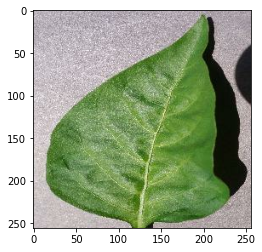

In [81]:
import numpy as np
for images_batch, labels_batch in test_bellpepperds.take(1):    # where 1 is the number of batches
    #print(images_batch[0])    #Tensor format
    #print(images_batch[0].numpy())     #Numpy format
    #plt.imshow(images_batch[0].numpy().astype('uint8'))    #Displays the actual image
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("Predicting the first image")
    plt.imshow(first_image)
    print("Actual class label:",bellpepper_class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted class label:",bellpepper_class_names[np.argmax(batch_prediction[0])])

In [82]:
#Creating a function for inference
def predict_model(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = bellpepper_class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

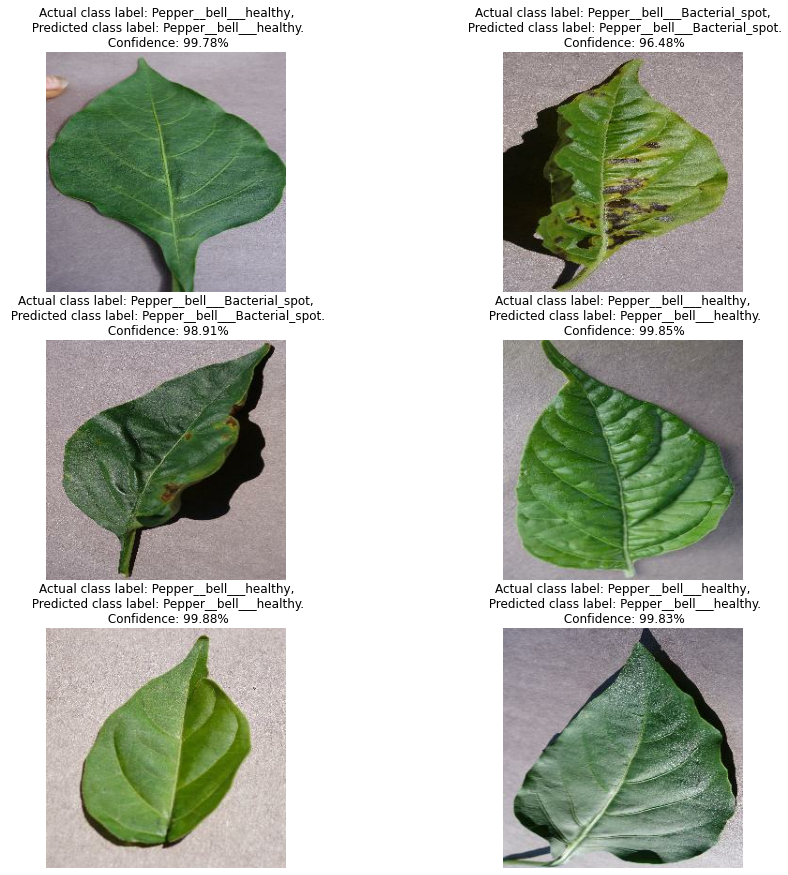

In [83]:
#Running the inference on few sample images
plt.figure(figsize=(15, 15))
for images, labels in test_bellpepperds.take(1):   #Taking 1 batch
    for i in range(6):    #Considering 9 images at a time
        ax = plt.subplot(3, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict_model(model, images[i].numpy())
        actual_class = bellpepper_class_names[labels[i]] 
        
        plt.title(f"Actual class label: {actual_class},\n Predicted class label: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")   #Removing the axes

In [84]:
df.loc[len(df.index)] = ['Bell Pepper', scores[1], scores[0]]

In [85]:
df

Plant  Accuracy      Loss
0       Potato  0.948864  0.124044
1  Bell Pepper  0.990385  0.024327

In [86]:
imageSize = 256   
batchSize = 32    
channels = 3      
epochs = 10

#Tomato Plant
tomato_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "tomatoPlant",
    shuffle=True,
    image_size = (imageSize,imageSize),
    batch_size = batchSize
)

Found 16011 files belonging to 10 classes.


In [87]:
class_names_tomato = tomato_dataset.class_names
class_names_tomato   #Names of folder present in PotatoPlant

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [88]:
len(tomato_dataset)

501

In [89]:
501*32

16032

In [90]:
for image_batch, label_batch in tomato_dataset.take(1):   #Considering 1 batch at a time
    print(image_batch.shape)
    print(label_batch.numpy())
#Basically it provides a batch size, image size and RGB channels
#label batch signifies the class number

(32, 256, 256, 3)
[4 3 5 3 9 6 9 1 1 2 7 7 6 9 7 6 9 4 9 2 6 2 4 4 2 4 0 2 5 0 5 0]


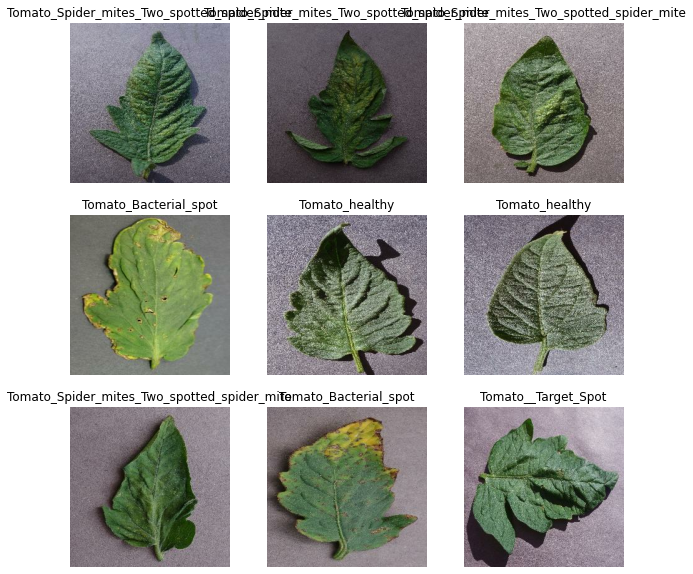

In [91]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in tomato_dataset.take(1):
    for i in range(9):    #here in range max value we can give is 32 bcoz batch size is 32
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names_tomato[label_batch[i]])
        plt.axis("off")

In [92]:
len(tomato_dataset)

501

In [93]:
# 70% -> Training dataset
# 15% -> Validation dataset
# 15% -> Testing dataset
train_size = 0.7
len(tomato_dataset)*train_size

350.7

In [94]:
train_tomatodataset = tomato_dataset.take(350)   # Considering first 350 values
len(train_tomatodataset)

350

In [95]:
test_tomatodataset = tomato_dataset.skip(350)    # Considering values after 350
len(test_tomatodataset)

151

In [96]:
validation_size = 0.15
len(tomato_dataset)*validation_size

75.14999999999999

In [97]:
validation_potatodataset = test_tomatodataset.take(75)    
len(validation_potatodataset)

75

In [98]:
test_tomatodataset = test_tomatodataset.skip(75)
len(test_tomatodataset)

76

In [99]:
train_tomatods, validation_tomatods, test_tomatods = get_dataset_partitions_tf(tomato_dataset)

In [100]:
print(len(train_tomatods))
print(len(validation_tomatods))
print(len(test_tomatods))

350
75
76


In [101]:
# Here cache is used to store the image so that we can read the image from the disk which improves the performance.
# Prefetch is used because if GPU is busy with training purpose meanwhile CPU will read the next batch so that the performance is optimized.
train_tomatods = train_tomatods.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_tomatods = validation_tomatods.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_tomatods = test_tomatods.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
#Thus we get the optimized Training, Validation and Testing dataset.

In [102]:
#Data preprocessing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(imageSize, imageSize),   #Supose if the size of image is not 256 then this will take care of that.
    layers.experimental.preprocessing.Rescaling(1.0/255)   #Rescaling the image to 255 and supply the layer when we actually build our model.
])

In [103]:
#Data augmentation :- Techniques used to increase the amount of data by adding slightly modified copies of already existing data
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])
#We just created layers for preprocessing and we will this layer in our actual model.

In [104]:
input_shape = (batchSize, imageSize, imageSize, channels)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'), #softmax function -> normalize the probability of your classes.
])

model.build(input_shape=input_shape)

In [105]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

In [106]:
model.compile(
        optimizer = 'adam',
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
        metrics = ['accuracy']   #to track the gradient descent/ training process.
)

In [107]:
epochs = 10
results_tomato = model.fit(
    train_tomatods,
    batch_size=batchSize,
    validation_data=validation_tomatods,
    verbose=1,
    epochs=epochs,
)

Epoch 1/10
350/350 [==============================] - 488s 1s/step - loss: 1.5135 - accuracy: 0.4544 - val_loss: 0.9590 - val_accuracy: 0.6683
Epoch 2/10
350/350 [==============================] - 420s 1s/step - loss: 0.7880 - accuracy: 0.7288 - val_loss: 0.5746 - val_accuracy: 0.7967
Epoch 3/10
350/350 [==============================] - 396s 1s/step - loss: 0.5448 - accuracy: 0.8101 - val_loss: 0.4292 - val_accuracy: 0.8487
Epoch 4/10
350/350 [==============================] - 401s 1s/step - loss: 0.4196 - accuracy: 0.8529 - val_loss: 0.2572 - val_accuracy: 0.9142
Epoch 5/10
350/350 [==============================] - 393s 1s/step - loss: 0.3527 - accuracy: 0.8785 - val_loss: 0.2521 - val_accuracy: 0.9129
Epoch 6/10
350/350 [==============================] - 397s 1s/step - loss: 0.2871 - accuracy: 0.9030 - val_loss: 0.2583 - val_accuracy: 0.9087
Epoch 7/10
350/350 [==============================] - 396s 1s/step - loss: 0.2338 - accuracy: 0.9175 - val_loss: 0.2098 - val_accuracy: 0.9271

In [108]:
scores = model.evaluate(test_tomatods)

76/76 [==============================] - 66s 244ms/step - loss: 0.1604 - accuracy: 0.9502


In [109]:
scores      #returns loss and accuracy

[0.1604328453540802, 0.9502466917037964]

In [110]:
results_tomato    #history

In [111]:
results_tomato.params

{'verbose': 1, 'epochs': 10, 'steps': 350}

In [112]:
results_tomato.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [113]:
accuracy = results_tomato.history['accuracy']
val_accuracy = results_tomato.history['val_accuracy']
loss = results_tomato.history['loss']
val_loss = results_tomato.history['val_loss']

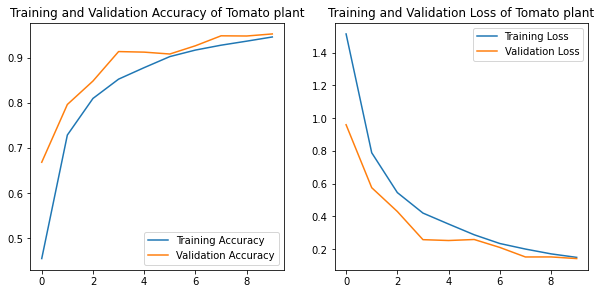

In [114]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(range(epochs), accuracy, label='Training Accuracy')
plt.plot(range(epochs), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy of Tomato plant')

plt.subplot(2, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss of Tomato plant')
plt.show()

Predicting the first image
Actual class label: Tomato__Tomato_YellowLeaf__Curl_Virus
Predicted class label: Tomato__Tomato_YellowLeaf__Curl_Virus


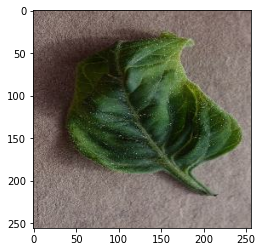

In [115]:
import numpy as np
for images_batch, labels_batch in test_tomatods.take(1):    # where 1 is the number of batches
    #print(images_batch[0])    #Tensor format
    #print(images_batch[0].numpy())     #Numpy format
    #plt.imshow(images_batch[0].numpy().astype('uint8'))    #Displays the actual image
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("Predicting the first image")
    plt.imshow(first_image)
    print("Actual class label:",class_names_tomato[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted class label:",class_names_tomato[np.argmax(batch_prediction[0])])

In [116]:
#Creating a function for inference
def predict_model(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names_tomato[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

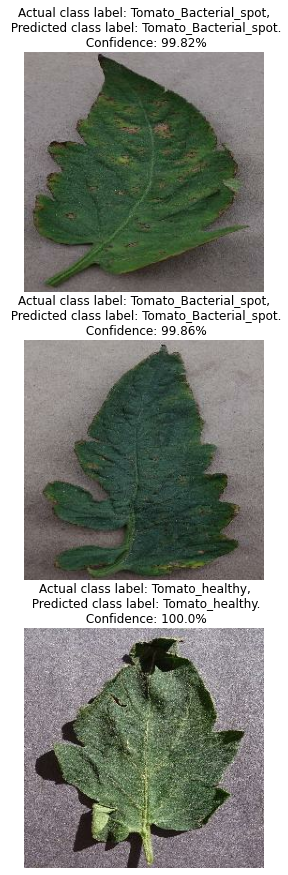

In [117]:
#Running the inference on few sample images
plt.figure(figsize=(15, 15))
for images, labels in test_tomatodataset.take(1):   #Taking 1 batch
    for i in range(3):    #Considering 9 images at a time
        ax = plt.subplot(3, 1, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict_model(model, images[i].numpy())
        actual_class = class_names_tomato[labels[i]] 
        
        plt.title(f"Actual class label: {actual_class},\n Predicted class label: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")   #Removing the axes

In [118]:
df.loc[len(df.index)] = ['Tomato', scores[1], scores[0]]

In [119]:
df

Plant  Accuracy      Loss
0       Potato  0.948864  0.124044
1  Bell Pepper  0.990385  0.024327
2       Tomato  0.950247  0.160433

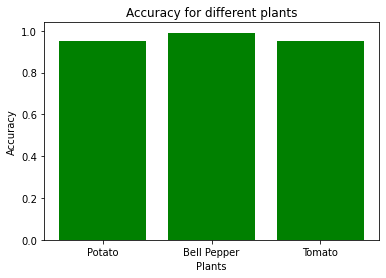

In [122]:
import matplotlib.pyplot as plt

plt.bar(df.Plant, df.Accuracy, color='green')
plt.title('Accuracy for different plants')
plt.xlabel('Plants')
plt.ylabel('Accuracy')
plt.show()

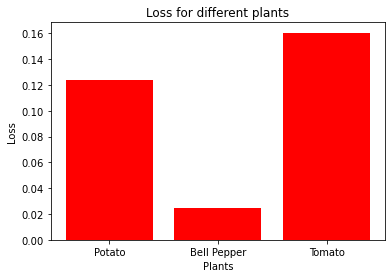

In [124]:
import matplotlib.pyplot as plt

plt.bar(df.Plant, df.Loss, color='red')
plt.title('Loss for different plants')
plt.xlabel('Plants')
plt.ylabel('Loss')
plt.show()